In [1]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torch import optim

In [3]:
from nflows.transforms.dropout import StochasticDropout
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.flows.base import Flow

In [4]:
x_drop_prob = np.random.rand(5)
p_drop_prob = x_drop_prob/(np.sum(x_drop_prob))
p_drop_prob_cum = np.cumsum(p_drop_prob)

def generate(n):
    x = np.random.rand(n, 4)
    mask = np.random.rand(n)[:,None] < p_drop_prob_cum
    mask = np.delete(mask, 4, 1)
    x[mask] = 0
    return x

In [5]:
n_data = int(1e6)
x_data = torch.tensor(generate(n_data), dtype=torch.float32)

In [6]:
base_dist = BoxUniform(torch.zeros(4), torch.ones(4))
transforms = []
transforms.append(StochasticDropout(torch.tensor([1,2,3,4]), hidden_layers=2))
transform = CompositeTransform(transforms)
flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [7]:
for name, param in flow.named_parameters():
    if param.requires_grad:
        print (name, param.data)

_transform._transforms.0._prob_net._layers.0.weight tensor([[ 0.2470, -0.4658,  0.4770, -0.0358],
        [ 0.2943,  0.4777, -0.3493, -0.2654],
        [ 0.3774, -0.1405, -0.1817, -0.3262],
        [-0.1225,  0.2245,  0.4965, -0.4211],
        [ 0.0165, -0.2453,  0.4501, -0.3403],
        [ 0.1287, -0.4723,  0.3021,  0.4987],
        [ 0.4474, -0.4444,  0.3665,  0.0451],
        [-0.0403, -0.4562,  0.1598,  0.1253],
        [-0.0597,  0.2512, -0.2008,  0.3089],
        [ 0.2559, -0.4074,  0.4582, -0.1511]])
_transform._transforms.0._prob_net._layers.0.bias tensor([ 0.0539,  0.1642, -0.2671,  0.2964, -0.3964,  0.0448, -0.1138, -0.4967,
         0.0529,  0.2028])
_transform._transforms.0._prob_net._layers.1.weight tensor([[-0.2896,  0.0445,  0.1385,  0.0413, -0.0563, -0.2309, -0.0920, -0.0710,
          0.0722,  0.1232],
        [ 0.1635, -0.0910,  0.0874, -0.1354, -0.2838,  0.1351, -0.0944, -0.2060,
          0.1910, -0.0043],
        [-0.2171, -0.2490, -0.0074,  0.1388, -0.0799,  0.034

In [8]:
n_epochs = 5
batch_size = 2
n_batches = m.ceil(x_data.shape[0]/batch_size)

for epoch in range(n_epochs):
    permutation = torch.randperm(x_data.shape[0])    

    # Loop over batches
    cum_loss = 0
    for batch in range(n_batches):
        # Set up the batch
        batch_begin = batch*batch_size
        batch_end   = min( (batch+1)*batch_size, x_data.shape[0]-1 )
        indices = permutation[batch_begin:batch_end]
        batch_x = x_data[indices]
        
        # Take a step
        optimizer.zero_grad()

        loss = -flow.log_prob(inputs=batch_x).mean()
        loss.backward()    
        optimizer.step()
    
        # Compute cumulative loss
        cum_loss = (cum_loss*batch + loss.item())/(batch+1)
        
    print("batch = ",batch+1, "/", n_batches, "loss = ", cum_loss)

KeyboardInterrupt: 

In [9]:
for name, param in flow.named_parameters():
    if param.requires_grad:
        print (name, param.data)

_transform._transforms.0._prob_net._layers.0.weight tensor([[-0.4077, -0.3682,  0.2995,  0.1588],
        [ 0.0324,  0.1688,  0.4236, -0.4535],
        [-0.2056, -0.2639,  0.3797, -0.2668],
        [ 0.4398, -0.3340,  0.2917,  0.2629],
        [ 0.4521, -0.0913, -0.4625, -0.1647],
        [ 0.1558,  0.1828, -0.1154, -0.2755],
        [ 0.1936, -0.4032,  0.4333, -0.4303],
        [-0.3477, -0.0721,  0.3887, -0.3572],
        [-0.2765,  0.4217,  0.3163,  0.3900],
        [-0.3717, -0.0663,  0.0445,  0.4137]])
_transform._transforms.0._prob_net._layers.0.bias tensor([ 0.2557,  0.0152,  0.4678,  0.1593, -0.4744,  0.4496, -0.3778, -0.4096,
        -0.1605,  0.1211])
_transform._transforms.0._prob_net._layers.1.weight tensor([[ 0.1271, -0.0440, -0.0131,  0.0641,  0.2434, -0.2485,  0.2546, -0.2111,
          0.1015, -0.1649],
        [-0.2253,  0.1926, -0.0362, -0.2250, -0.1022,  0.2635,  0.1283,  0.1615,
         -0.2389,  0.2739],
        [-0.1888,  0.0330, -0.3084, -0.0479, -0.1623,  0.141

In [9]:
with torch.no_grad():
    x_flow = flow.sample(n_data)

RuntimeError: invalid multinomial distribution (encountering probability entry < 0)

(array([210960., 192004., 157443., 229808., 209785.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 1 Patch objects>)

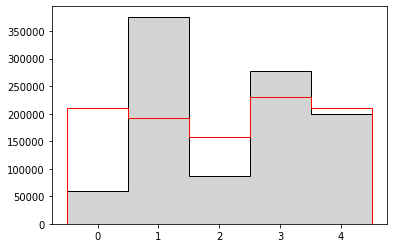

In [11]:
plt.hist(np.count_nonzero(x_data.numpy(), axis=1), np.linspace(-0.5,4.5,6), histtype='stepfilled', edgecolor="black", facecolor="lightgray")
plt.hist(np.count_nonzero(x_flow.numpy(), axis=1), np.linspace(-0.5,4.5,6), edgecolor="red", histtype="step")

In [12]:
np.linspace(-0.5,4.5,6)

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5])

In [13]:
x_data[11].numpy()

array([0.89749837, 0.        , 0.        , 0.        ], dtype=float32)